<h1 align="center" style="font-size:38px">MRI BrainAge</h1>

Inspired by the groundbreaking paper titled "**[Accurate brain‐age models for routine clinical MRI examinations](https://www.sciencedirect.com/science/article/pii/S1053811922000015?via%3Dihub)**", this project develops an advanced predictive model using volumetric features extracted with **SynthSeg (FreeSurfer)** from high-resolution **3D T1-w brain MRIs**. It aims to estimate brain age accurately, detecting subtle deviations between chronological and biological brain age, that provide evidence that Alzheimer’s Disease is strongly associated with patterns of accelerated brain ageing.

Using datasets from **ADNI**, **AIBL**, and **OASIS**, I collected **7545 MRI scans** from **2227 unique patients** for analysis.<br/>
These scans belong exclusively to two diagnostic categories:

* Cognitively Normal `CN` **68.68%**
* Alzheimer's Disease `AD` **31.32%**

The analysis involved two complementary approaches to explore the relationship between brain structure, age, and Alzheimer’s Disease. The first approach focused on **Brain Age Estimation and Brain PAD**, where a multiple polynomial regression model was trained using data from CN subjects, with chronological age as the dependent variable and volumetric features as independent variables. The model was then used to infer the brain age of AD subjects. The **Brain Predicted Age Difference (Brain PAD)**, calculated as the difference between predicted brain age and chronological age, demonstrated that AD patients exhibit significantly higher Brain PAD values compared to CN patients, providing evidence of accelerated brain aging in Alzheimer’s Disease.

The second approach employed **Classification Using Quadratic Discriminant Analysis** to distinguish between CN and AD subjects. A QDA classifier was carefully trained using selected brain volumes and age as features, aiming to find the quadratic combination of these features that best separates the two diagnostic groups. By maximizing the separation between the classes while minimizing the variance within each class, the model effectively captured the differences in brain volumes and their relationship with age. This enabled a reliable and consistent distinction between cognitively normal individuals and those diagnosed with Alzheimer’s Disease.

## Environment Configuration

This section sets up the required libraries and dependencies for the project. It ensures that all necessary Python packages are installed with specific versions to maintain **consistency** and **reproducibility** of the results. Additionally, key modules for data preprocessing, visualization, regression analysis, and classification tasks are imported.

In [1]:
%%capture
%pip install numpy==1.26.4
%pip install pandas==2.2.2
%pip install seaborn==0.13.2
%pip install matplotlib==3.8.4
%pip install scikit-learn==1.5.2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Utility Functions

This section serves as a collection of reusable code snippets that enhance the clarity and modularity of the project. These functions simplify repetitive tasks and streamline the main analysis pipeline, ensuring the code remains **clean** and **maintainable**. By abstracting frequently used operations, they improve both the efficiency and **readability** of the notebook.

In [3]:
# Removes outliers from predicted age data based on the difference between predicted and true values.
# The threshold is defined as twice the standard deviation of the absolute differences.
# Author: Antonio Scardace
# Version: 1.0

def remove_outliers(true_age: pd.Series, predicted_age: np.ndarray) -> tuple[pd.Series, np.ndarray]:
    delta = np.abs(predicted_age - true_age)
    threshold = 2 * np.std(delta)
    return true_age[delta <= threshold], predicted_age[delta <= threshold]

# Plots a chart for a given data series.
# Allows flexibility to choose the type of chart, color, and axis labels.
# Author: Antonio Scardace
# Version: 1.0

def plot_chart(data: pd.Series, kind: str, color: Union[str, list[str]], ylabel: str) -> None:
    data.plot(kind=kind, color=color, figsize=(4, 3), rot=0)
    plt.ylabel(ylabel, labelpad=16)
    plt.xlabel('')
    plt.show()

# Plots a scatterplot of predicted vs true age and the ideal fit line (y=x).
# Allows flexibility to choose the color and the label.
# Author: Antonio Scardace
# Version: 1.0

def plot_age_scatter(true_age: pd.Series, pred_age: np.ndarray, ax: plt.Axes, color: str, label: str) -> None:
    sns.set_theme(style='whitegrid', palette='muted')
    sns.scatterplot(x=true_age, y=pred_age, color=color, label=label, ax=ax, alpha=0.6, s=20)
    sns.lineplot(x=true_age, y=true_age, color='black', ax=ax, label='Ideal Fit', linewidth=1)
    ax.set_xlabel('True Age (years)', labelpad=16)
    ax.set_ylabel('Predicted Age (years)', labelpad=16)
    ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
    ax.grid(True, linestyle='--', alpha=0.5)

## Dataset Presentation

The [volumes CSV](/data/raw/volumes.csv) obtained from SynthSeg, measured in millimeters cubed (mm<sup>3</sup>), was merged with a [metadata CSV](/data/raw/metadata.csv) containing demographic information to form the [final dataset](/data/processed/merged_dataset.csv). For analysis, I prepared a [normalised CSV file](/data/processed/normalised_dataset.csv) focusing on volumes of brain regions that are relevant to both CN and AD subjects. Left and right hemisphere volumes were summed for each structure, and all values were normalised by total head size to ensure comparability across subjects. To facilitate regression and classification algorithms, categorical variables were converted into dummy variables: `sex` was transformed from `M` and `F` to `0` and `1`, respectively, and `diagnosis` from `CN` and `AD` to `0` and `1`, respectively.<br/><br/>

<table style="text-align: left; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="border: 1px solid black; padding: 8px;">Name</th>
      <th style="border: 1px solid black; padding: 8px;">Type</th>
      <th style="border: 1px solid black; padding: 8px;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>subject_id</code></td>
      <td style="border: 1px solid black; padding: 8px;">str</td>
      <td style="border: 1px solid black; padding: 8px;">Unique ID for the subject to ensure anonymization.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>image_id</code></td>
      <td style="border: 1px solid black; padding: 8px;">str</td>
      <td style="border: 1px solid black; padding: 8px;">Unique ID for the scan.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>dataset_name</code></td>
      <td style="border: 1px solid black; padding: 8px;">str</td>
      <td style="border: 1px solid black; padding: 8px;">Indicates the dataset of origin.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>study_name</code></td>
      <td style="border: 1px solid black; padding: 8px;">str</td>
      <td style="border: 1px solid black; padding: 8px;">Specifies the study within the dataset.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>chronological_age</code></td>
      <td style="border: 1px solid black; padding: 8px;">int</td>
      <td style="border: 1px solid black; padding: 8px;">The subject’s chronological age.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>diagnosis</code></td>
      <td style="border: 1px solid black; padding: 8px;">int</td>
      <td style="border: 1px solid black; padding: 8px;">Indicates the subject’s diagnosis.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>sex</code></td>
      <td style="border: 1px solid black; padding: 8px;">int</td>
      <td style="border: 1px solid black; padding: 8px;">Indicates the subject’s biological gender.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>head_size</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Total head size, segmented from SynthSeg, used for volume normalization.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>csf</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Cerebrospinal fluid cushions the brain and spinal cord, and supports nutrient transport.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>third_ventricle</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Part of the CSF system that helps cushion the brain and remove waste.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>fourth_ventricle</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">A key structure circulating cerebrospinal fluid between the brain and spinal cord.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>cerebral_white_matter</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Facilitates communication between brain regions.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>cerebral_cortex</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Responsible for higher cognitive functions such as reasoning, language, and problem-solving.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>lateral_ventricle</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Contains cerebrospinal fluid, which helps cushion the brain and remove metabolic waste.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>inferior_lateral_ventricle</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">A small part of the ventricular system containing cerebrospinal fluid.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>thalamus</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Relays sensory and motor signals to the cortex and regulates consciousness.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>hippocampus</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Essential for memory formation and spatial navigation.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>amygdala</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Processes emotions like fear and aggression, and is involved in memory consolidation.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;"><code>accumbens_area</code></td>
      <td style="border: 1px solid black; padding: 8px;">float</td>
      <td style="border: 1px solid black; padding: 8px;">Part of the brain’s reward and motivation system, regulating pleasure and reinforcement.</td>
    </tr>
  </tbody>
</table>

In [4]:
DATASET_PATH = 'data/interim/merged_dataset.csv'
dataset = pd.read_csv(DATASET_PATH)

In [5]:
NORMALISED_DATASET_PATH = 'data/processed/normalised_dataset.csv'
normalised_dataset = pd.read_csv(NORMALISED_DATASET_PATH)

## Dataset Overview: Exploratory Data Analysis (EDA)

This section presents an overview of the dataset, consisting of data from 2227 subjects and 7545 scans. The dataset includes various demographic and diagnostic information, allowing for a detailed exploratory data analysis (EDA). 

The subjects in the dataset are almost evenly split between **sexes**, with 50.8% identified as female and 49.2% identified as male. The data come from three primary **sources**, with the majority from the ADNI dataset, accounting for 69.5% of the total, followed by OASIS (21.42%), and a smaller portion from AIBL (9.08%). The subjects are also categorized by **diagnosis**. Of the 2227 individuals in the dataset, 68.68% are classified as cognitively normal (CN), while 31.32% have been diagnosed with Alzheimer’s disease (AD). Regarding **age**, the dataset spans a wide range, with the minimum age being 43 years and the maximum age of 96 years. The median age is 75 years, while the mean age is slightly lower at 74.28 years, with a standard deviation of 7.76 years. The distribution of age in the dataset is **mildly negatively skewed**, with a skewness value of -0.33, suggesting that the distribution is slightly biased toward older individuals but is overall fairly balanced, and this is consistent with the nature of the dataset which is enriched for studies on Alzheimer’s disease and brain ageing. Importantly, this distribution aligns with the age groups most affected by AD, enhancing the dataset’s relevance for studying brain health.

Overall, the dataset is well-suited for exploring the intersection of brain ageing, sex differences, and Alzheimer’s disease. The balance in sex distribution minimizes demographic biases, while the diagnostic composition and age range offers insights into both normal and pathological ageing. The skew toward older ages is a strength, given the focus on Alzheimer’s disease, but also necessitates careful stratification during analysis to ensure findings are representative.

In [6]:
print('Analysed', dataset['subject_id'].drop_duplicates().count(), 'subjects')
print('Analysed', dataset['image_id'].count(), 'scans')

Analysed 2227 subjects
Analysed 7545 scans


In [7]:
sex_counts_df = dataset['sex'].value_counts().to_frame().reset_index()
sex_counts_df['percentage'] = (sex_counts_df['count'] / len(dataset) * 100).round(2)
sex_counts_df

,sex,count,percentage
0,F,3833,50.8
1,M,3712,49.2


In [8]:
dataset_name_counts_df = dataset['dataset_name'].value_counts().to_frame().reset_index()
dataset_name_counts_df['percentage'] = (dataset_name_counts_df['count'] / len(dataset) * 100).round(2)
dataset_name_counts_df

,dataset_name,count,percentage
0,ADNI,5244,69.50
1,OASIS,1616,21.42
2,AIBL,685,9.08


In [9]:
diagnosis_counts_df = dataset['diagnosis'].value_counts().to_frame().reset_index()
diagnosis_counts_df['percentage'] = (diagnosis_counts_df['count'] / len(dataset) * 100).round(2)
diagnosis_counts_df

,diagnosis,count,percentage
0,CN,5182,68.68
1,AD,2363,31.32


In [10]:
print('Minimum Age:', dataset['age'].min(), 'years')
print('Maximum Age:', dataset['age'].max(), 'years')
print('Median Age:', dataset['age'].median(), 'years')
print('Mean Age:', round(dataset['age'].mean(), 2), 'years')
print('Standard Deviation:', round(dataset['age'].std(), 2), 'years')
print('Skewness:', round(dataset['age'].skew(), 2))

Minimum Age: 43 years
Maximum Age: 96 years
Median Age: 75.0 years
Mean Age: 74.28 years
Standard Deviation: 7.76 years
Skewness: -0.33


## Dataset Overview: Visualisation

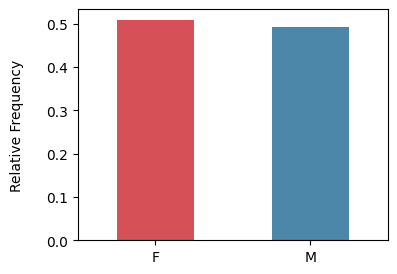

In [11]:
sex_counts = dataset['sex'].value_counts(normalize=True)
plot_chart(sex_counts, 'bar', ['#D55057', '#4C86A8'], 'Relative Frequency')

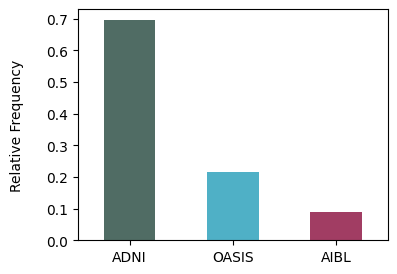

In [12]:
dataset_name_counts = dataset['dataset_name'].value_counts(normalize=True)
plot_chart(dataset_name_counts, 'bar', ['#506C64', '#4FB0C6', '#A13D63'], 'Relative Frequency')

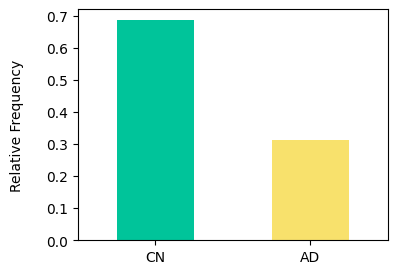

In [13]:
diagnosis_counts = dataset['diagnosis'].value_counts(normalize=True)
plot_chart(diagnosis_counts, 'bar', ['#00C49A', '#F8E16C'], 'Relative Frequency')

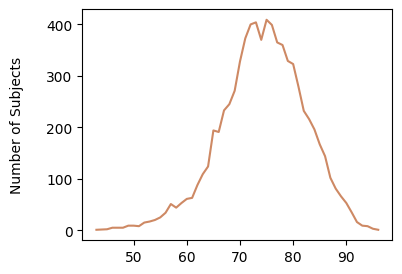

In [14]:
age_counts = dataset['age'].value_counts().sort_index()
plot_chart(age_counts, 'line', '#CE8964', 'Number of Subjects')

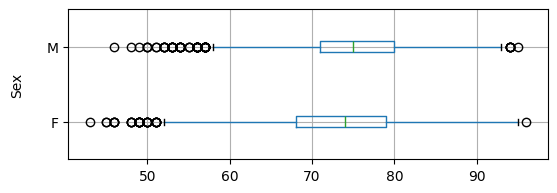

In [15]:
dataset.boxplot(column=['age'], by='sex', figsize=(6, 2), vert=False)
plt.ylabel('Sex', labelpad=16)
plt.suptitle('')
plt.title('')
plt.show()

## Training the BrainAge Regressor

After experimenting with different hyperparameters and models, a **third-degree polynomial regressor** with interaction terms and no regularization emerged as the optimal choice. This decision was based on rigorous **5-fold Cross-Validation**. The model demonstrated strong performance, achieving an **R-squared of 0.69** and a **MAE of 3.98 years** in testing. This aligns perfectly with the results of the reference paper `3 < MAE < 4`, which used 3D scans and a neural network.

The statistical significance of the independent variables was assessed using p-values. Most variables had **p-values < 0.05**, while `amygdala` exhibited a **p-value > 0.05**, suggesting limited significance. However, backward elimination revealed that removing it slightly reduced model performance, as evidenced by a lower R-squared score and a higher MAE. This indicates that retaining `amygdala` contributes to the overall predictive capability of the model.

Since the regressor was trained exclusively on CN data, the dataset was filtered to include only observations corresponding to this category. The CN subset was then split into a **Training Set** `70%` and a **Test Set** `30%`. This meticulous approach ensured that the model was trained on representative data while remaining generalizable for unseen observations.

In [16]:
cn_data = normalised_dataset[normalised_dataset['diagnosis'] == 0]
ad_data = normalised_dataset[normalised_dataset['diagnosis'] == 1]

cn_train_data, cn_test_data = train_test_split(cn_data, train_size=0.7, random_state=42)
print('Training set size:', len(cn_train_data), 'CN scans')
print('Test set size:', len(cn_test_data), 'CN scans')

Training set size: 3627 CN scans
Test set size: 1555 CN scans


In [17]:
independent_variables = [
    'sex',
    'third_ventricle',
    'fourth_ventricle',
    'csf',
    'cerebral_white_matter',
    'cerebral_cortex',
    'lateral_ventricle',
    'inferior_lateral_ventricle',
    'thalamus',
    'hippocampus',
    'amygdala',
    'accumbens_area'
]

In [18]:
pipeline = Pipeline(memory=None, steps=[
    ('polynomial_features', PolynomialFeatures(degree=3, interaction_only=False)),
    ('linear_regression', LinearRegression())
])

pipeline.fit(cn_train_data[independent_variables], cn_train_data['chronological_age'])
y_train_pred = pipeline.predict(cn_train_data[independent_variables])
y_test_pred = pipeline.predict(cn_test_data[independent_variables])

print('R-squared Score:', round(r2_score(cn_train_data['chronological_age'], y_train_pred), 4))
print('Testing MAE:', round(mean_absolute_error(cn_test_data['chronological_age'], y_test_pred), 4), 'years')

R-squared Score: 0.6942
Testing MAE: 3.9864 years


## BrainPAD Metrics: Revealing Alzheimer’s Accelerated Ageing

This subsection analyzes Brain PAD (Predicted Age Difference), which measures the gap between an individual’s brain age and chronological age. It is a useful tool for assessing the alignment of biological and chronological aging, especially in conditions like Alzheimer’s Disease. Using the brain age regressor trained on CN data, we calculate the average **Brain PAD** for both CN and AD groups. For the CN group, the results show a close alignment between biological and chronological age, confirming the regressor’s accuracy. In contrast, the AD group exhibits a significant positive Brain PAD, indicating accelerated biological aging in Alzheimer’s, highlighting the substantial gap between brain and chronological age in this condition.

In [19]:
ad_predictions = pipeline.predict(ad_data[independent_variables])
cn_predictions = pipeline.predict(cn_test_data[independent_variables])

ad_mean_brain_pad = (ad_predictions - ad_data['chronological_age']).mean()
cn_mean_brain_pad = (cn_predictions - cn_test_data['chronological_age']).mean()
print('Mean Brain PAD for AD subjects:', ad_mean_brain_pad.round(2), 'years')
print('Mean Brain PAD for CN subjects:', cn_mean_brain_pad.round(2), 'years')

Mean Brain PAD for AD subjects: 7.48 years
Mean Brain PAD for CN subjects: -0.12 years


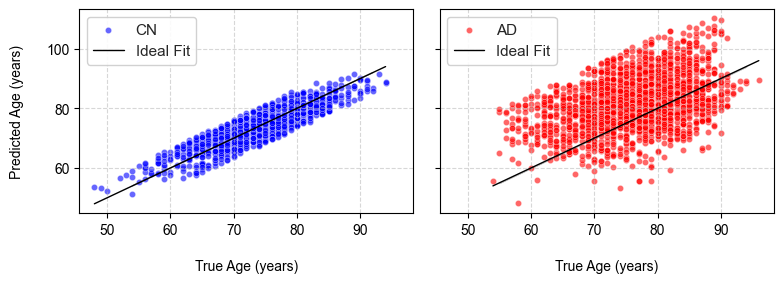

In [20]:
cn_true_age, cn_pred_age = remove_outliers(cn_test_data['chronological_age'], cn_predictions)
ad_true_age, ad_pred_age = remove_outliers(ad_data['chronological_age'], ad_predictions)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
plot_age_scatter(cn_true_age, cn_pred_age, axes[0], color='blue', label='CN')
plot_age_scatter(ad_true_age, ad_pred_age, axes[1], color='red', label='AD')
plt.tight_layout()
plt.show()

## Training the BrainAge Classifier

In this section, the dataset was split into a **Training Set** `70%` and a **Test Set** `30%`. This approach ensured that the model was trained remaining generalizable for unseen observations. Along with the features already present in the dataset, such as brain volumes, sex, and chronological age, the previously trained regressor was used to add a new feature: the **biological age** of the brain. The inclusion of this feature demonstrated its contribution to improving classification performance.

For the classification model, I chose **Quadratic Discriminant Analysis (QDA)** due to its ability to capture non-linear boundaries between classes by leveraging quadratic combinations of the features. I benchmarked its performance against several other classifiers in the following order of performance: Linear Discriminant Analysis (LDA), Naive Bayes, K-Nearest Neighbors (KNN) with `K=4`, which all delivered comparable results. However, Maximum A Posteriori (MAP) lagged significantly behind the others, making QDA the clear choice. This comparison was conducted using a **validation set** to ensure the most suitable model was selected.

The QDA classifier achieved an **Accuracy of 88%**, **F1-Score of 79%**, and **AUC of 83%**, demonstrating solid performance. What’s particularly notable is that this was accomplished without the complexity of using 3D MRI scans or deep learning models. In a [previous project](https://github.com/antonioscardace/Tina), I tested a CNN model using 3D MRI data with **MONAI’s DenseNet**, which outperformed the QDA in accuracy and other metrics. However, the QDA’s simpler approach, using selected brain volume features, achieved comparable results, highlighting its efficiency and ability to deliver strong performance without the need for computationally expensive 3D data and deep learning models.

In [21]:
biological_age = pipeline.predict(normalised_dataset[independent_variables])
normalised_dataset['biological_age'] = biological_age

train_data, test_data = train_test_split(normalised_dataset, train_size=0.7, random_state=42)
print('Training set size:', len(train_data), 'scans')
print('Test set size:', len(test_data), 'scans')

Training set size: 5281 scans
Test set size: 2264 scans


In [22]:
features = [
    'chronological_age',
    'biological_age',
    'sex',
    'third_ventricle',
    'fourth_ventricle',
    'csf',
    'cerebral_white_matter',
    'cerebral_cortex',
    'lateral_ventricle',
    'inferior_lateral_ventricle',
    'thalamus',
    'hippocampus',
    'amygdala',
    'accumbens_area'
]

In [23]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(train_data[features], train_data['diagnosis'])

y_true = test_data['diagnosis']
y_pred = qda.predict(test_data[features])

print('Test Accuracy:', round(accuracy_score(y_true, y_pred), 4))
print('Test Precision:', round(precision_score(y_true, y_pred), 4))
print('Test Recall:', round(recall_score(y_true, y_pred), 4))
print('Test F1-Score:', round(f1_score(y_true, y_pred), 4))
print('Test AUC:', round(roc_auc_score(y_true, y_pred), 4))

Test Accuracy: 0.8807
Test Precision: 0.8684
Test Recall: 0.7247
Test F1-Score: 0.79
Test AUC: 0.8377


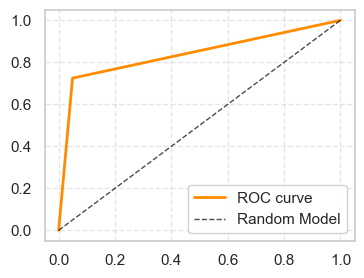

In [24]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(4, 3))
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', lw=1, alpha=0.7, linestyle='--', label='Random Model')
plt.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Conclusions

This project allowed me to apply both the theoretical and practical knowledge acquired throughout the course, offering hands-on experience in a real-world context. By training a multiple polynomial regression model using Cross-Validation, I gained insights into how predictive models can be used to estimate complex biological parameters, such as brain age. The model’s performance, with a **MAE of 3.98 years**, and its ability to differentiate brain age in CN and AD patients, provided valuable understanding of how Alzheimer’s disease is associated with accelerated brain ageing. Specifically, the average Brain PAD for AD patients was found to be **+7.48 years**, which supports our hypothesis that Alzheimer’s disease is linked to accelerated brain aging.

Moreover, the application of Quadratic Discriminant Analysis (QDA) for classification, achieving an **Accuracy of 88%** and an **AUC of 83%**, showcased the potential of using simpler models with selected features for disease diagnosis. The use of QDA further emphasized the importance of selecting appropriate models and feature selection to improve prediction accuracy.

Beyond the technical skills, this project allowed me to delve into a topic of personal interest: Alzheimer’s disease. This project not only helped me put theory into practice but also sparked further interest in the **medical AI research**, particularly in brain disorders. It was a valuable opportunity to blend technical expertise with a genuine curiosity about the human brain.

A special thanks to **Dr. Lemuel Puglisi** for suggesting the idea.